In [1]:
import numpy as np
import cv2
import os
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.losses import MeanSquaredError
from keras.applications.vgg19 import VGG19
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Dense, Add, Reshape, PReLU, UpSampling2D, Lambda, LeakyReLU, Flatten
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard
import glob
import random
from numpy import asarray
from itertools import repeat
import imageio
from imageio import imread
from PIL import Image
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

print("Tensorflow version " + tf.__version__)
print("Keras version " + tf.keras.__version__)

Tensorflow version 2.11.0
Keras version 2.11.0


## Resizing the images to 128x128 and 32x32 to feed into the SRGAN

In [ ]:
from PIL import Image
import os

input_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train/DME'
output_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_us/DME'

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    with Image.open(input_path) as img:
        img = img.resize((128, 128), resample=Image.LANCZOS)
        img.save(output_path)

from PIL import Image
import os

input_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train/DRUSEN'
output_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_us/DRUSEN'

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    with Image.open(input_path) as img:
        img = img.resize((128, 128), resample=Image.LANCZOS)
        img.save(output_path)

In [ ]:
from PIL import Image
import os

input_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test/DME'
output_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test_us/DME'

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    with Image.open(input_path) as img:
        img = img.resize((128, 128), resample=Image.LANCZOS)
        img.save(output_path)

from PIL import Image
import os

input_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test/DRUSEN'
output_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test_us/DRUSEN'

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    with Image.open(input_path) as img:
        img = img.resize((128, 128), resample=Image.LANCZOS)
        img.save(output_path)

In [ ]:
from PIL import Image
import os

input_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train/DME'
output_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_ds/DME'

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    with Image.open(input_path) as img:
        img = img.resize((32, 32), resample=Image.LANCZOS)
        img.save(output_path)

from PIL import Image
import os

input_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train/DRUSEN'
output_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_ds/DRUSEN'

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    with Image.open(input_path) as img:
        img = img.resize((32, 32), resample=Image.LANCZOS)
        img.save(output_path)

In [ ]:
from PIL import Image
import os

input_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test/DME'
output_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test_ds/DME'

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    with Image.open(input_path) as img:
        img = img.resize((32, 32), resample=Image.LANCZOS)
        img.save(output_path)

from PIL import Image
import os

input_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test/DRUSEN'
output_folder = '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test_ds/DRUSEN'

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    with Image.open(input_path) as img:
        img = img.resize((32, 32), resample=Image.LANCZOS)
        img.save(output_path)

In [58]:
from keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Conv2D, UpSampling2D, Add
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
import keras.backend as K

def build_generator(input_shape):
    input_low_res = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=9, strides=1, padding='same')(input_low_res)
    x = LeakyReLU(alpha=0.2)(x)

    # Residual blocks
    for i in range(16):
        residual = x
        x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Add()([x, residual])

    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=2)(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
    x = UpSampling2D(size=2)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Output high resolution image
    output_high_res = Conv2D(3, kernel_size=9, strides=1, padding='same', activation='tanh')(x)

    return Model(input_low_res, output_high_res)

In [59]:
def build_discriminator(input_shape):
    input_high_res = Input(shape=input_shape)

    # VGG19 model as a feature extractor
    vgg19 = VGG19(weights='imagenet')
    for layer in vgg19.layers:
        layer.trainable = False
    vgg19 = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)

    # Discriminator model
    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(input_high_res)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    # Compile model
    model = Model(input_high_res, x)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

    return model

In [43]:
# def build_SR_GAN(input_shape):
#     # Build and compile the discriminator
#     discriminator = build_discriminator(input_shape)
#     discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
    
#     # Build the generator
#     generator = build_generator()
    
#     # Build the SRGAN model by stacking the generator and discriminator
#     input_low_res = Input(shape=input_shape)
#     generated_high_res = generator(input_low_res)
#     validity = discriminator(generated_high_res)
    
#     # Freeze the discriminator during the generator training
#     discriminator.trainable = False
    
#     # Define the combined model for training the generator
#     # The generator's loss function includes the adversarial loss and the perceptual loss
#     srgan = Model(input_low_res, [generated_high_res, validity])
#     srgan.compile(loss=['mse', 'binary_crossentropy'], loss_weights=[1e-3, 1], optimizer=Adam(lr=0.0002, beta_1=0.5))
    
#     return srgan

In [60]:
def build_SR_GAN(input_shape):

    # Build the discriminator
    discriminator = build_discriminator(input_shape)

    # Build the generator
    generator = build_generator(input_shape)

    # Build the SRGAN model by stacking the generator and discriminator
    sr_gan = Sequential()
    sr_gan.add(generator)
    sr_gan.add(discriminator)

    return sr_gan

In [39]:
# def build_SR_GAN(input_shape):
#     # Build the generator
#     generator = build_generator(input_shape)

#     # Build the discriminator
#     discriminator = build_discriminator()

#     # Set discriminator weights to non-trainable
#     discriminator.trainable = False

#     # Build the SRGAN model by stacking the generator and discriminator
#     sr_gan = Sequential()
#     sr_gan.add(generator)
#     sr_gan.add(discriminator)

#     return sr_gan


In [61]:
# Define a function to preprocess the low-resolution images
def preprocess_LR(img):
    img = img.resize((128, 128))
    img = np.array(img)
    img = img / 127.5 - 1.0
    return img

In [62]:
# Define a function to preprocess the high-resolution images
def preprocess_HR(img):
    img = np.array(img)
    img = img / 127.5 - 1.0
    return img

In [ ]:
# # Load the low-resolution images from the train and test folders
# train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_LR)
# train_generator = train_data_gen.flow_from_directory('/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_downsampled', target_size=(32, 32), class_mode=None, batch_size=16)
# test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_LR)
# test_generator = test_data_gen.flow_from_directory('/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test_downsampled', target_size=(32, 32), class_mode=None, batch_size=16)

# # Load the high-resolution images from the train and test folders
# train_data_gen_HR = ImageDataGenerator(preprocessing_function=preprocess_HR)
# train_generator_HR = train_data_gen_HR.flow_from_directory('/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train', target_size=(128, 128), class_mode=None, batch_size=16)
# test_data_gen_HR = ImageDataGenerator(preprocessing_function=preprocess_HR)
# test_generator_HR = test_data_gen_HR.flow_from_directory('/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test', target_size=(128, 128), class_mode=None, batch_size=16)


In [63]:
# # Load the low-resolution images from the train and test folders
# train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_LR)
# train_generator = train_data_gen.flow_from_directory('/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_ds', target_size=(32, 32), class_mode=None, batch_size=16)
# test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_LR)
# test_generator = test_data_gen.flow_from_directory('/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test_ds', target_size=(32, 32), class_mode=None, batch_size=16)

# # Load the high-resolution images from the train and test folders
# train_data_gen_HR = ImageDataGenerator(preprocessing_function=preprocess_HR)
# train_generator_HR = train_data_gen_HR.flow_from_directory('/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_us', target_size=(128, 128), class_mode=None, batch_size=16)
# test_data_gen_HR = ImageDataGenerator(preprocessing_function=preprocess_HR)
# test_generator_HR = test_data_gen_HR.flow_from_directory('/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test_us', target_size=(128, 128), class_mode=None, batch_size=16)


Found 2534 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Found 2534 images belonging to 2 classes.
Found 514 images belonging to 2 classes.


In [ ]:
# train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_downsampled',
#         target_size=(32, 32),
#         batch_size=32,
#         class_mode=None)

# train_generator_HR = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train128',
#         target_size=(128, 128),
#         batch_size=32,
#         class_mode=None)

# test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test_downsampled',
#         target_size=(32, 32),
#         batch_size=32,
#         class_mode=None)

# test_generator_HR = ImageDataGenerator(rescale=1./255).flow_from_directory(
#         '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test128',
#         target_size=(128, 128),
#         batch_size=32,
#         class_mode=None)

In [ ]:
# srgan = build_SR_GAN((32, 32, 3))
# srgan.compile(optimizer='adam', loss='mse')
# srgan.fit(train_generator, epochs=50, validation_data=test_generator)

In [64]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_ds',
    target_size=(32, 32),
    batch_size=32,
    class_mode=None
)

def generate_images(generator):
    for lr_batch, hr_batch in generator:
        yield lr_batch, hr_batch

train_generator_HR = generate_images(ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_us',
    target_size=(128, 128),
    batch_size=32,
    class_mode=None
))

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test_ds',
    target_size=(32, 32),
    batch_size=32,
    class_mode=None
)

test_generator_HR = generate_images(ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/test_us',
    target_size=(128, 128),
    batch_size=32,
    class_mode=None
))


Found 2534 images belonging to 2 classes.
Found 2534 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Found 514 images belonging to 2 classes.


## Loading up the 32x32 Images

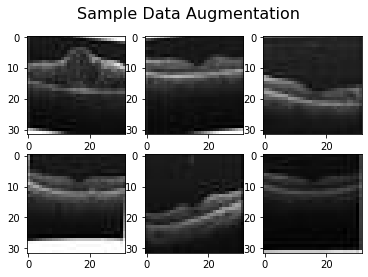

sample img, max value:  0.93725497
sample img, min value:  0.0


In [70]:
X_preview = train_generator.next()

for k in range(1,7):
    sample_img = X_preview[k,:,:,:]
    plt.subplot(2, 3, k)
    plt.imshow(sample_img)
plt.suptitle('Sample Data Augmentation', fontsize = 16)    
plt.show()

print('sample img, max value: ',np.max(sample_img))
print('sample img, min value: ',np.min(sample_img))

In [72]:
train_generator2 = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/4090_AI_Biomedical/OCT_dataset/datasets/Data_Small/train_us',
    target_size=(128, 128),
    batch_size=32,
    class_mode=None
)

Found 2534 images belonging to 2 classes.


## Loading up the 128x128 Images

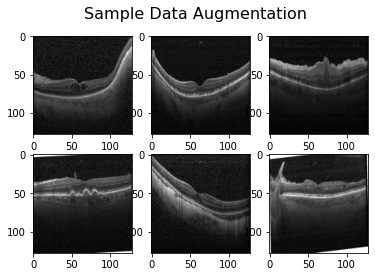

sample img, max value:  1.0
sample img, min value:  0.0


In [73]:
X_preview = train_generator2.next()

for k in range(1,7):
    sample_img = X_preview[k,:,:,:]
    plt.subplot(2, 3, k)
    plt.imshow(sample_img)
plt.suptitle('Sample Data Augmentation', fontsize = 16)    
plt.show()

print('sample img, max value: ',np.max(sample_img))
print('sample img, min value: ',np.min(sample_img))

### Trying to train the SRGAN model

In [65]:
srgan = build_SR_GAN((32, 32, 3))
srgan.compile(optimizer='adam', loss='mse')
srgan.fit(train_generator, epochs=50, validation_data=test_generator)

Epoch 1/50


ValueError: ignored

# Can't figure out how to debug incompatiable shapes